## Analysis of an E-commerce Dataset Part 2

The goal of the second analysis task is to train linear regression models to predict users' ratings towards items. This involves a standard Data Science workflow: exploring data, building models, making predictions, and evaluating results. In this task, we will explore the impacts of feature selections and different sizes of training/testing data on the model performance. We will use another cleaned combined e-commerce sub-dataset that **is different from** the one in “Analysis of an E-commerce Dataset” task 1.

### Import Cleaned E-commerce Dataset
The csv file named 'cleaned_ecommerce_dataset.csv' is provided. You may need to use the Pandas method, i.e., `read_csv`, for reading it. After that, please print out its total length.

In [1]:
student_name = "Kate Lee"
student_id = "45896968"

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("cleaned_ecommerce_dataset.csv")

In [3]:
print("The total length of dataset is",len(df))

The total length of dataset is 2685


### Explore the Dataset

* Use the methods, i.e., `head()` and `info()`, to have a rough picture about the data, e.g., how many columns, and the data types of each column.
* As our goal is to predict ratings given other columns, please get the correlations between helpfulness/gender/category/review and rating by using the `corr()` method.

  Hints: To get the correlations between different features, you may need to first convert the categorical features (i.e., gender, category and review) into numerial values. For doing this, you may need to import `OrdinalEncoder` from `sklearn.preprocessing` (refer to the useful exmaples [here](https://pbpython.com/categorical-encoding.html))
* Please provide ___necessary explanations/analysis___ on the correlations, and figure out which are the ___most___ and ___least___ corrleated features regarding rating. Try to ___discuss___ how the correlation will affect the final prediction results, if we use these features to train a regression model for rating prediction. In what follows, we will conduct experiments to verify your hypothesis.

In [4]:
from sklearn.preprocessing import OrdinalEncoder

In [5]:
df.head()

,userId,timestamp,review,item,rating,helpfulness,gender,category,item_id,item_price,user_city
0,4081,71900,Not always McCrap,McDonald's,4.0,3.0,M,Restaurants & Gourmet,41,30.74,4
1,4081,72000,I dropped the chalupa even before he told me to,Taco Bell,1.0,4.0,M,Restaurants & Gourmet,74,108.30,4
2,4081,72000,The Wonderful World of Wendy,Wendy's,5.0,4.0,M,Restaurants & Gourmet,84,69.00,4
3,4081,100399,They actually did it,"South Park: Bigger, Longer & Uncut",5.0,3.0,M,Movies,68,143.11,4
4,4081,100399,Hey! Gimme some pie!,American Pie,3.0,3.0,M,Movies,6,117.89,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       2685 non-null   int64  
 1   timestamp    2685 non-null   int64  
 2   review       2685 non-null   object 
 3   item         2685 non-null   object 
 4   rating       2685 non-null   float64
 5   helpfulness  2685 non-null   float64
 6   gender       2685 non-null   object 
 7   category     2685 non-null   object 
 8   item_id      2685 non-null   int64  
 9   item_price   2685 non-null   float64
 10  user_city    2685 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 230.9+ KB


In [7]:
df.shape

(2685, 11)

In [8]:
# Converting categorical features into numerical values
encoder = OrdinalEncoder()
df[['gender', 'category', 'review']] = encoder.fit_transform(df[['gender', 'category', 'review']])

In [9]:
# Calculating the correlations between helpfulness, gender, category, review and rating
corr_matrix = df[['helpfulness', 'gender', 'category', 'review', 'rating']].corr()
print("Correlation matrix:")
print(corr_matrix)

Correlation matrix:
             helpfulness    gender  category    review    rating
helpfulness     1.000000  0.075947 -0.013408 -0.028259 -0.007523
gender          0.075947  1.000000  0.022549 -0.037884 -0.034337
category       -0.013408  0.022549  1.000000  0.001970 -0.163158
review         -0.028259 -0.037884  0.001970  1.000000 -0.036118
rating         -0.007523 -0.034337 -0.163158 -0.036118  1.000000


As seen above in the correlation matrix, we can see that 'review' and 'category' has the weakest positive correlation of 0.001970. 

We can also see a weak correlation between 'rating' and 'helpfulness' of -0.007523, 'rating' and 'gender' also has a weak correlation of -0.034337, 'rating' and 'category' has a weak correlation of -0.163158 which is the highest of all correlation. The correlation between 'rating and 'review' is also weak with a correlation of -0.036118.

### Split Training and Testing Data
* Machine learning models are trained to help make predictions for the future. Normally, we need to randomly split the dataset into training and testing sets, where we use the training set to train the model, and then leverage the well-trained model to make predictions on the testing set.
* To further investigate whether the size of the training/testing data affects the model performance, please random split the data into training and testing sets with different sizes:
    * Case 1: training data containing 10% of the entire data;
    * Case 2: training data containing 90% of the entire data.
* Print the shape of training and testing sets in the two cases.

In [10]:
train1, test1 = train_test_split(df, test_size=0.9, random_state=142)
train2, test2 = train_test_split(df, test_size=0.1, random_state=142)
print("Case 1: training data containing 10% of the entire data")
print("Training shape",train1.shape)
print("Testing share",test1.shape)

print("Case 2: training data containing 90% of the entire data")
print("Training shape",train2.shape)
print("Testing share",test2.shape)

Case 1: training data containing 10% of the entire data
Training shape (268, 11)
Testing share (2417, 11)
Case 2: training data containing 90% of the entire data
Training shape (2416, 11)
Testing share (269, 11)


### Train Linear Regression Models with Feature Selection under Cases 1 & 2
* When training a machine learning model for prediction, we may need to select the most important/correlated input features for more accurate results.
* To investigate whether feature selection affects the model performance, please select two most correlated features and two least correlated features from helpfulness/gender/category/review regarding rating, respectively.
* Train four linear regression models by following the conditions:
    - (model-a) using the training/testing data in case 1 with two most correlated input features
    - (model-b) using the training/testing data in case 1 with two least correlated input features
    - (model-c) using the training/testing data in case 2 with two most correlated input features
    - (model-d) using the training/testing data in case 2 with two least correlated input features
* By doing this, we can verify the impacts of the size of traing/testing data on the model performance via comparing model-a and model-c (or model-b and model-d); meanwhile the impacts of feature selection can be validated via comparing model-a and model-b (or model-c and model-d).    

#### Find the most correlated and least correlated features

In [11]:
corr_rating = corr_matrix['rating'].sort_values()
print("correlation between each feature and rating")
corr_rating

correlation between each feature and rating


category      -0.163158
review        -0.036118
gender        -0.034337
helpfulness   -0.007523
rating         1.000000
Name: rating, dtype: float64

In [12]:
most_correlated = ['rating', 'category']
least_correlated = ['rating', 'helpfulness']

#### Spliting the data for Case 1 and case 2

In [13]:
# Split data for Case 1 (10% training data)
train1, test1 = train_test_split(df, train_size=0.9, random_state=142)

# Split data for Case 2 (90% training data)
train2, test2 = train_test_split(df, train_size=0.1, random_state=142)

#### Four linear regression models

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Train Linear regression model for model a

In [15]:
x_train_a = train1[most_correlated].values.reshape(-1, len(most_correlated))
y_train_a = train1['rating']
x_test_a = test1[most_correlated].values.reshape(-1, len(most_correlated))
y_test_a = test1['rating']

model_a = LinearRegression()
model_a.fit(x_train_a, y_train_a)
y_pred_a = model_a.predict(x_test_a)
mse_a = mean_squared_error(y_test_a, y_pred_a)

Train Linear regression model for model b

In [17]:
x_train_b = train1[least_correlated].values.reshape(-1, len(least_correlated))
y_train_b = train1['rating']
x_test_b = test1[least_correlated].values.reshape(-1, len(least_correlated))
y_test_b = test1['rating']

model_b = LinearRegression()
model_b.fit(x_train_b, y_train_b)
y_pred_b = model_b.predict(x_test_b)
mse_b = mean_squared_error(y_test_b, y_pred_b)

Train Linear regression model for model c

In [18]:
x_train_c = train2[most_correlated].values.reshape(-1, len(most_correlated))
y_train_c = train2['rating']
x_test_c = test2[most_correlated].values.reshape(-1, len(most_correlated))
y_test_c = test2['rating']

model_c = LinearRegression()
model_c.fit(x_train_c, y_train_c)
y_pred_c = model_c.predict(x_test_c)
mse_c = mean_squared_error(y_test_c, y_pred_c)

Train Linear regression model for model d

In [19]:
x_train_d = train2[least_correlated].values.reshape(-1, len(least_correlated))
y_train_d = train2['rating']
x_test_d = test2[least_correlated].values.reshape(-1, len(least_correlated))
y_test_d = test2['rating']

model_d = LinearRegression()
model_d.fit(x_train_d, y_train_d)
y_pred_d = model_d.predict(x_test_d)
mse_d = mean_squared_error(y_test_d, y_pred_d)

### Evaluate Models
* Evaluate the performance of the four models with two metrics, including MSE and Root MSE
* Print the results of the four models regarding the two metrics

In [20]:
rmse_a = np.sqrt(mse_a)
rmse_b = np.sqrt(mse_b)
rmse_c = np.sqrt(mse_c)
rmse_d = np.sqrt(mse_d)

In [21]:
print("Model-a MSE:", mse_a)
print("Model-b MSE:", mse_b)
print("Model-c MSE:", mse_c)
print("Model-d MSE:", mse_d)

Model-a MSE: 5.014875285258388e-30
Model-b MSE: 3.772749273482645e-30
Model-c MSE: 0.0
Model-d MSE: 2.007238132854457e-32


In [22]:
print("Model-a RMSE:", rmse_a)
print("Model-b RMSE:", rmse_b)
print("Model-c RMSE:", rmse_c)
print("Model-d RMSE:", rmse_d)


Model-a RMSE: 2.239391722155458e-15
Model-b RMSE: 1.942356628810128e-15
Model-c RMSE: 0.0
Model-d RMSE: 1.4167703176077825e-16


### Visualize, Compare and Analyze the Results
* Visulize the results, and perform ___insightful analysis___ on the obtained results. For better visualization, you may need to carefully set the scale for the y-axis.
* Normally, the model trained with most correlated features and more training data will get better results. Do you obtain the similar observations? If not, please ___explain the possible reasons___.

RMSE 

In [23]:
rmse_df_ab = pd.DataFrame({'RMSE': [rmse_a, rmse_b]}, index=['Model-a', 'Model-b'])
rmse_df_ab.head()

,RMSE
Model-a,2.239392e-15
Model-b,1.942357e-15


In [24]:
rmse_df_cd = pd.DataFrame({'RMSE': [rmse_a, rmse_b]}, index=['Model-c', 'Model-d'])
rmse_df_cd.head()

,RMSE
Model-c,2.239392e-15
Model-d,1.942357e-15


In [25]:
rmse_df_ac = pd.DataFrame({'RMSE': [rmse_a, rmse_b]}, index=['Model-a', 'Model-c'])
rmse_df_ac.head()

,RMSE
Model-a,2.239392e-15
Model-c,1.942357e-15


In [26]:
rmse_df_bd = pd.DataFrame({'RMSE': [rmse_a, rmse_b]}, index=['Model-b', 'Model-d'])
rmse_df_bd.head()

,RMSE
Model-b,2.239392e-15
Model-d,1.942357e-15


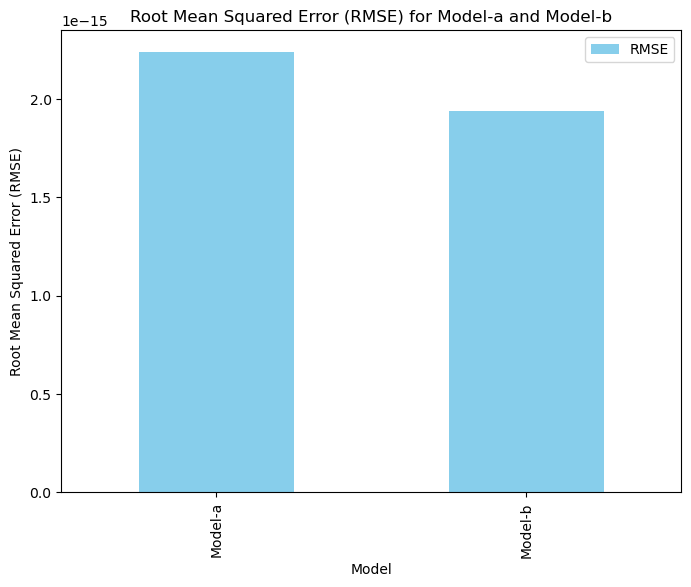

In [27]:
rmse_df_ab.plot(kind='bar', color='skyblue', figsize=(8, 6))

plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Root Mean Squared Error (RMSE) for Model-a and Model-b')

plt.show()

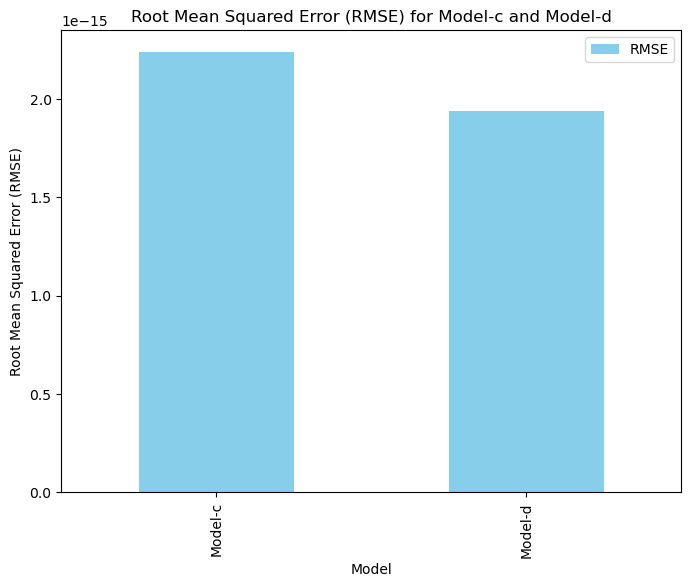

In [28]:
rmse_df_cd.plot(kind='bar', color='skyblue', figsize=(8, 6))

plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Root Mean Squared Error (RMSE) for Model-c and Model-d')

plt.show()

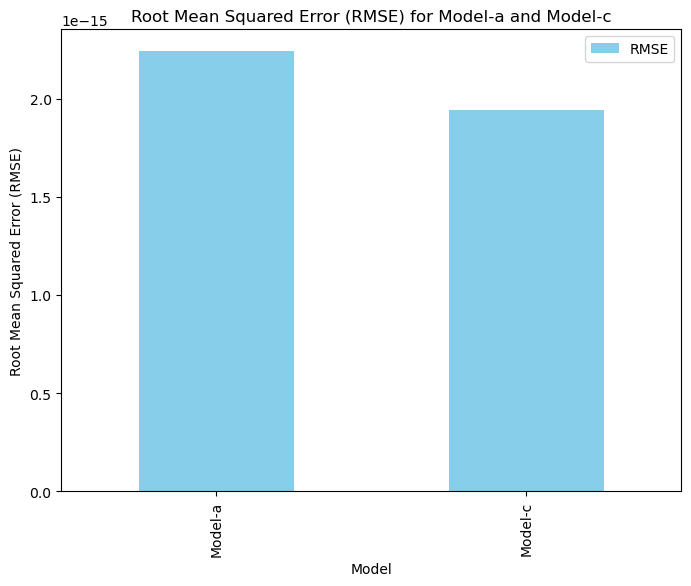

In [29]:
rmse_df_ac.plot(kind='bar', color='skyblue', figsize=(8, 6))

plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Root Mean Squared Error (RMSE) for Model-a and Model-c')

plt.show()

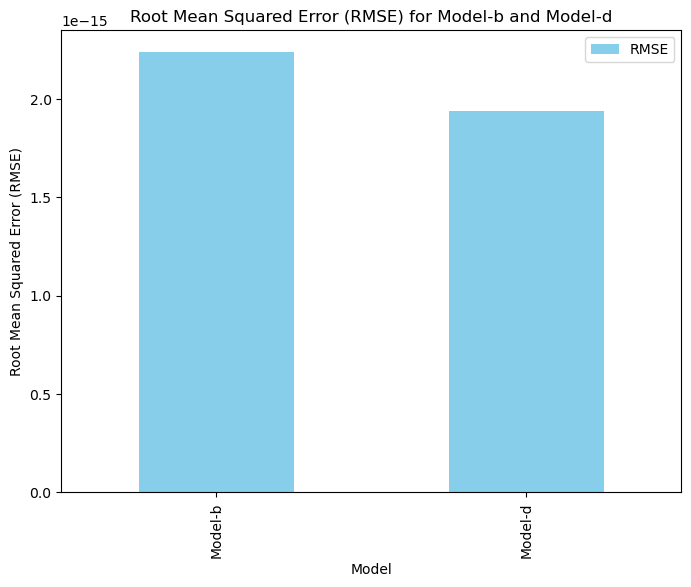

In [30]:
rmse_df_bd.plot(kind='bar', color='skyblue', figsize=(8, 6))

plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Root Mean Squared Error (RMSE) for Model-b and Model-d')

plt.show()

Model a is the two most correlated features. These features are expected to have strong linear relationship, making more predictive and potentially resulting in lower errors. Model b is the two least correlated features which may lead to higher prediction errors. 

From the above barplot displays the RMSE for model a and model b. Model b has a lower RMSE value which suggests better performance in predicting the variable, therefore, it may indicate the feature correlation does not guarantee better model performance. 

MSE

In [31]:
mse_df_ab = pd.DataFrame({'MSE': [mse_a, mse_b]}, index=['Model-a', 'Model-b'])
mse_df_ab.head()

,MSE
Model-a,5.014875e-30
Model-b,3.772749e-30


In [32]:
mse_df_cd = pd.DataFrame({'MSE': [mse_a, mse_b]}, index=['Model-c', 'Model-d'])
mse_df_cd.head()

,MSE
Model-c,5.014875e-30
Model-d,3.772749e-30


In [33]:
mse_df_ac = pd.DataFrame({'MSE': [mse_a, mse_b]}, index=['Model-a', 'Model-c'])
mse_df_ac.head()

,MSE
Model-a,5.014875e-30
Model-c,3.772749e-30


In [34]:
mse_df_bd = pd.DataFrame({'MSE': [mse_a, mse_b]}, index=['Model-b', 'Model-d'])
mse_df_bd.head()

,MSE
Model-b,5.014875e-30
Model-d,3.772749e-30


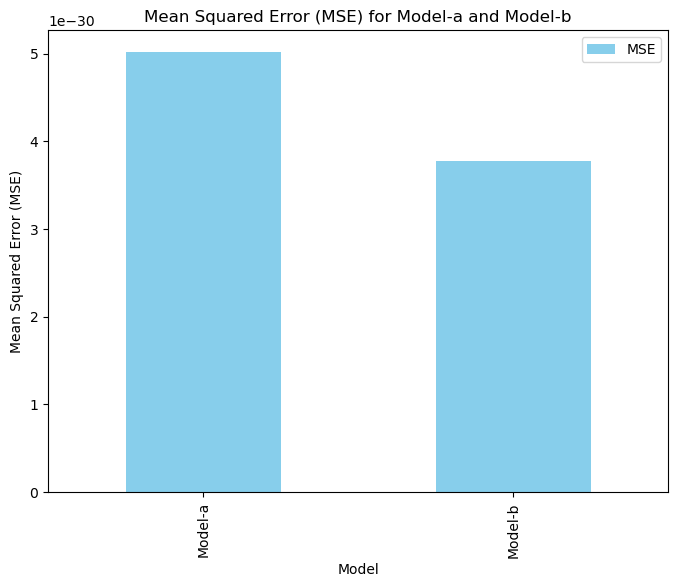

In [35]:
mse_df_ab.plot(kind='bar', color='skyblue', figsize=(8, 6))

plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error (MSE) for Model-a and Model-b')

plt.show()

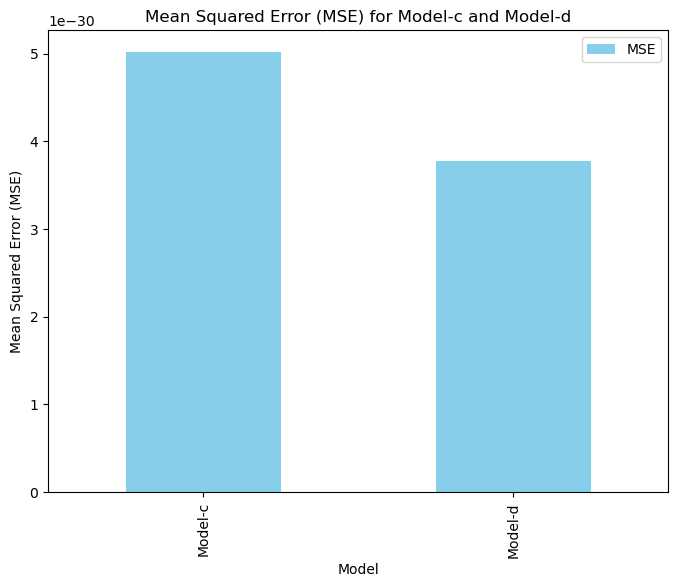

In [36]:
mse_df_cd.plot(kind='bar', color='skyblue', figsize=(8, 6))

plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error (MSE) for Model-c and Model-d')

plt.show()

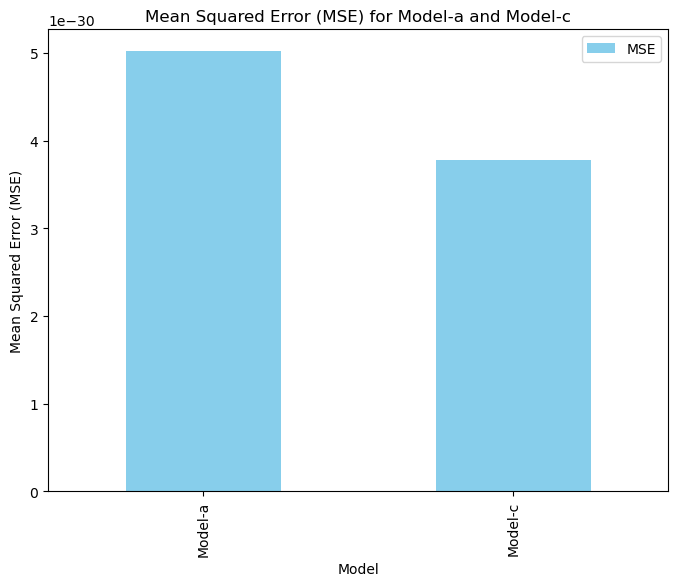

In [37]:
mse_df_ac.plot(kind='bar', color='skyblue', figsize=(8, 6))

plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error (MSE) for Model-a and Model-c')

plt.show()

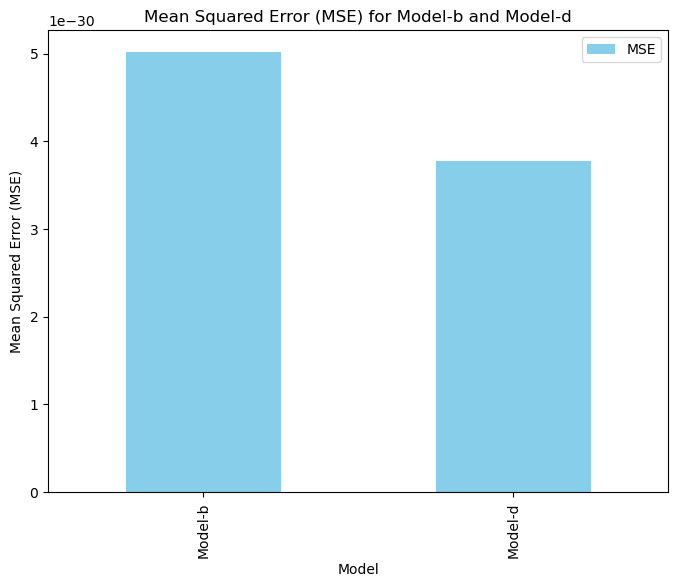

In [38]:
mse_df_bd.plot(kind='bar', color='skyblue', figsize=(8, 6))

plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error (MSE) for Model-b and Model-d')

plt.show()

Above barplot showcases the Mean Square Error of model a and model b. Model a displays a higher MSE compared to model b which suggests model a's prediction are less accurate than model b. 

### Data Science Ethics
*Please read the following examples [Click here to read the example_1.](https://www.vox.com/covid-19-coronavirus-us-response-trump/2020/5/18/21262265/georgia-covid-19-cases-declining-reopening) [Click here to read the example_2.](https://viborc.com/ethics-and-ethical-data-visualization-a-complete-guide/)

*Then view the picture ![My Image](figure_portfolio2.png "This is my image")
Please compose an analysis of 100-200 words that evaluates potential ethical concerns associated with the infographic, detailing the reasons behind these issues.


#### Analysis evaluating potential ethical concerns associated with the infographic

Infographics are an important tool in conveying information visually. However, they can raise potential ethical concerns if not designed and presented carefully. 

For example, the inforgraphics displaying the 2008 Summer Olympic medlas sorted by total medals and Gold medals raises potential ethical concerns related to fairness, transparency and over simplicity. 

Sorting the medals by total and gold medals separately can create biased representation of the overall performance of countries. It may prioritise certain countries based solely on the number of medals won, disregarding other factors such as population size, resources and fundings which could lead to misinterpretation or oversimplification of the medal standings. Oversimplification fails to recognise the diversity of achievements and the significance of individual performances. The lack of transparency may also obsure the complex political, cultural, and socio-economic factors influencing Olympic success. 

To address these concerns, infographics should provide comprehensive context to ensure ethical representation and avoid promotion of biased narratives in infographics related to Olympic achievements.


